In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import warnings
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from statsmodels.tsa.stattools import adfuller

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)

warnings.filterwarnings("ignore", category=UserWarning, module="gym")

In [4]:
class PairsTrading(gym.Env):
    """
    A Gymnasium environment for pairs trading with cryptocurrency.
    
    Actions:
    - 0: No position
    - 1: Long asset1, Short asset2
    - 2: Short asset1, Long asset2
    
    Observation:
    - Current z-score
    - Current position
    - Previous positions
    """
    
    def __init__(self, asset1, asset2, start_date, end_date, window=20, transaction_cost=0.001, conversion=None, reverse=False):
        super(PairsTrading, self).__init__()
        
        self.asset1 = asset1
        self.asset2 = asset2
        self.conversion = conversion
        self.window = window
        self.transaction_cost = transaction_cost
        self.reverse = reverse
        
        # Download data
        self.df = self._prepare_data(start_date, end_date)
        
        # Define action and observation spaces
        self.action_space = spaces.Discrete(3)  # 0: no position, 1: long-short, 2: short-long
        
        # Observation space: [z-score, current_position, historical_positions]
        self.history_length = 5  # Number of previous positions to include in state
        self.observation_space = spaces.Box(
            low=np.array([-10, 0] + [0] * self.history_length),
            high=np.array([10, 2] + [2] * self.history_length),
            dtype=np.float32
        )
        
        # Initialize state variables
        self.current_step = self.window  # Start after we have enough data for rolling window
        self.current_position = 0  # Initialize with no position
        self.position_history = [0] * self.history_length
        self.portfolio_value = 1.0
        self.done = False
        
    def _prepare_data(self, start_date, end_date):
        """Prepare the pair data including ratio and z-score."""
        df = yf.download([self.asset1, self.asset2], start=start_date, end=end_date, 
                        auto_adjust=True, progress=False)["Close"]
        
        if (self.conversion is not None):
            rate = yf.download(self.conversion, start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]
            df [self.asset1] *= rate[self.conversion]
            
        df["ratio"] = df[self.asset1] / df[self.asset2]

        if (self.reverse):
            df.loc[:, :] = df.iloc[::-1].values
            
        df.dropna(inplace=True)
        df["ratio_ma"] = df["ratio"].rolling(window=self.window).mean()
        df["ratio_std"] = df["ratio"].rolling(window=self.window).std()
        df["z_score"] = (df["ratio"] - df["ratio_ma"]) / df["ratio_std"]
        
        df[f"{self.asset1} return"] = df[self.asset1].pct_change()
        df[f"{self.asset2} return"] = df[self.asset2].pct_change()
        
        df.dropna(inplace=True)
        return df
    
    def reset(self, seed=None, options=None):
        """Reset the environment to the initial state."""
        super().reset(seed=seed)
        
        self.current_step = self.window
        self.current_position = 0
        self.position_history = [0] * self.history_length
        self.portfolio_value = 1.0
        self.done = False
        
        return self._get_observation(), {}
    
    def _get_observation(self):
        """Return the current state observation."""
        z_score = self.df["z_score"].iloc[self.current_step]
        return np.array([z_score, self.current_position] + self.position_history, dtype=np.float32)
    
    def step(self, action):
        """
        Take a step in the environment.
        
        Args:
            action (int): 0 for no position, 1 for long asset1/short asset2, 2 for short asset1/long asset2
        
        Returns:
            observation, reward, done, truncated, info
        """
        if self.done:
            return self._get_observation(), 0, True, False, {}
        
        # Convert action to position
        new_position = action
        if action == 2:
            new_position = -1  # Convert action 2 to position -1 (short-long)
        
        # Calculate returns for current step
        asset1_return = self.df[f"{self.asset1} return"].iloc[self.current_step + 1]
        asset2_return = self.df[f"{self.asset2} return"].iloc[self.current_step + 1]
        
        # Calculate transaction costs
        transaction_cost = 0
        if self.current_position != new_position:
            # Cost for closing previous position (if any)
            if self.current_position != 0:
                transaction_cost += self.transaction_cost * 2  # Cost for both assets
                
            # Cost for opening new position (if any)
            if new_position != 0:
                transaction_cost += self.transaction_cost * 2  # Cost for both assets
        
        # Calculate trade returns
        trade_return = 0
        if new_position == 1:  # Long asset1, Short asset2
            trade_return = asset1_return - asset2_return
        elif new_position == -1:  # Short asset1, Long asset2
            trade_return = asset2_return - asset1_return
            
        # Update portfolio value
        reward = trade_return - transaction_cost
        self.portfolio_value *= (1 + reward)
        
        # Update position history
        self.position_history.pop(0)
        self.position_history.append(self.current_position)
        
        # Update current position
        self.current_position = new_position
        
        # Move to next step
        self.current_step += 1
        
        # Check if we've reached the end of the data
        if self.current_step >= len(self.df) - 1:
            self.done = True
        
        info = {
            'portfolio_value': self.portfolio_value,
            'trade_return': trade_return,
            'transaction_cost': transaction_cost,
            'z_score': self.df["z_score"].iloc[self.current_step]
        }
        
        return self._get_observation(), reward, self.done, False, info
    
    def render(self, mode='human'):
        """Render the environment."""
        z_score = self.df["z_score"].iloc[self.current_step]
        position_text = ["No position", "Long-Short", "Short-Long"][self.current_position+1]
        
        print(f"Step: {self.current_step}, Z-Score: {z_score:.2f}, Position: {position_text}")
        print(f"Portfolio Value: {self.portfolio_value:.4f}")
        
    def get_performance_metrics(self):
        """Calculate and return performance metrics."""
        returns = pd.Series(self.portfolio_value).pct_change().dropna()
        
        if len(returns) > 0:
            sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
            max_drawdown = (1 - self.portfolio_value / np.maximum.accumulate(self.portfolio_value))
            
            return {
                'final_value': self.portfolio_value,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown.max() if len(max_drawdown) > 0 else 0
            }
        else:
            return {
                'final_value': self.portfolio_value,
                'sharpe_ratio': 0,
                'max_drawdown': 0
            }

In [5]:
def visualize_trades(env, actions, portfolio_values):
    """
    Visualize trades with asset prices and buy/sell indicators.
    
    Args:
        env: The pairs trading environment
        actions: List of actions taken at each step
        portfolio_values: List of portfolio values at each step
    """
    # Extract data from environment
    df = env.df.copy()
    df_trades = df.iloc[env.window:env.window + len(actions)].copy()
    
    # Convert actions to positions for both assets
    positions = []
    current_position = 0
    
    for action in actions:
        if action == 0:
            current_position = 0
        elif action == 1:
            current_position = 1  # Long asset1, Short asset2
        elif action == 2:
            current_position = -1  # Short asset1, Long asset2
        
        positions.append(current_position)
    
    # Create a DataFrame with actions and positions
    df_trades['action'] = actions
    df_trades['position'] = positions
    
    # Identify trade entry and exit points
    df_trades['position_change'] = df_trades['position'].diff()
    
    # Buy/sell signals for asset1
    df_trades['buy_asset1'] = ((df_trades['position_change'] == 1) | 
                              (df_trades['position_change'] == 2))
    df_trades['sell_asset1'] = ((df_trades['position_change'] == -1) | 
                               (df_trades['position_change'] == -2))
    
    # Buy/sell signals for asset2 (opposite of asset1)
    df_trades['buy_asset2'] = ((df_trades['position_change'] == -1) | 
                              (df_trades['position_change'] == -2))
    df_trades['sell_asset2'] = ((df_trades['position_change'] == 1) | 
                               (df_trades['position_change'] == 2))
    
    # Create subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), 
                                           gridspec_kw={'height_ratios': [2, 1, 1, 2]})
    
    # Plot 1: Asset Prices with Buy/Sell indicators
    ax1.plot(df_trades.index, df_trades[env.asset1], label=env.asset1, color='blue', alpha=0.7)
    ax1.plot(df_trades.index, df_trades[env.asset2], label=env.asset2, color='orange', alpha=0.7)
    
    # Add buy/sell markers for asset1
    buy_dates1 = df_trades[df_trades['buy_asset1']].index
    sell_dates1 = df_trades[df_trades['sell_asset1']].index
    
    buy_prices1 = df_trades.loc[buy_dates1, env.asset1]
    sell_prices1 = df_trades.loc[sell_dates1, env.asset1]
    
    ax1.scatter(buy_dates1, buy_prices1, color='green', marker='^', s=100, label=f'Buy {env.asset1}')
    ax1.scatter(sell_dates1, sell_prices1, color='red', marker='v', s=100, label=f'Sell {env.asset1}')
    
    # Add buy/sell markers for asset2
    buy_dates2 = df_trades[df_trades['buy_asset2']].index
    sell_dates2 = df_trades[df_trades['sell_asset2']].index
    
    buy_prices2 = df_trades.loc[buy_dates2, env.asset2]
    sell_prices2 = df_trades.loc[sell_dates2, env.asset2]
    
    ax1.scatter(buy_dates2, buy_prices2, color='lightgreen', marker='^', s=60, label=f'Buy {env.asset2}')
    ax1.scatter(sell_dates2, sell_prices2, color='lightcoral', marker='v', s=60, label=f'Sell {env.asset2}')
    
    # Adjust plot properties
    ax1.set_title('Bitcoin Prices with Trade Indicators', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis to show dates better
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Price Ratio and Moving Average
    ax2.plot(df_trades.index, df_trades['ratio'], label='Price Ratio', color='purple')
    ax2.plot(df_trades.index, df_trades['ratio_ma'], label='MA', color='black', linestyle='--')
    ax2.set_title(f'Price Ratio ({env.asset1}/{env.asset2})', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Z-Score
    ax3.plot(df_trades.index, df_trades['z_score'], label='Z-Score', color='blue')
    
    # Add reference lines
    ax3.axhline(y=2.0, color='red', linestyle='--', label='Reference (+2)')
    ax3.axhline(y=-2.0, color='red', linestyle='--', label='Reference (-2)')
    ax3.axhline(y=0.5, color='green', linestyle=':', label='Reference (+0.5)')
    ax3.axhline(y=-0.5, color='green', linestyle=':', label='Reference (-0.5)')
    ax3.axhline(y=0, color='black', linestyle='-')
    
    ax3.set_title('Z-Score of Ratio', fontsize=14)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 4: Portfolio Value
    ax4.plot(df_trades.index, portfolio_values[1:], label='Portfolio Value', color='green')
    
    # Shade background based on position
    for i in range(len(df_trades) - 1):
        date = df_trades.index[i]
        next_date = df_trades.index[i+1] if i < len(df_trades) - 1 else df_trades.index[i]
        position = df_trades['position'].iloc[i]
        
        if position == 1:  # Long asset1, Short asset2
            ax4.axvspan(date, next_date, alpha=0.2, color='green')
        elif position == -1:  # Short asset1, Long asset2
            ax4.axvspan(date, next_date, alpha=0.2, color='red')
    
    ax4.set_title('Portfolio Value', fontsize=14)
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    # Add portfolio performance text
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
    max_drawdown = np.max(1 - portfolio_values / np.maximum.accumulate(portfolio_values))
    
    performance_text = (
        f"Final Value: {portfolio_values[-1]:.2f}\n"
        f"Sharpe Ratio: {sharpe_ratio:.2f}\n"
        f"Max Drawdown: {max_drawdown:.2%}\n"
        f"Total Trades: {df_trades['position_change'].abs().sum() / 2:.0f}"
    )
    
    ax4.text(0.02, 0.05, performance_text, transform=ax4.transAxes, 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

In [ ]:
def train_rl_agent():
    """Train a reinforcement learning agent on the pairs trading environment."""
    print("Starting RL agent training...")
    
    train_env = PairsTrading(
        asset1='BTC-EUR',
        asset2='BTC-USD',
        start_date='2021-02-21',
        end_date='2024-02-20',
        window=10,
        transaction_cost=0.0015,
        conversion="EURUSD=X"
    )
    
    model = PPO(
        'MlpPolicy', 
        train_env, 
        verbose=1,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01
    )
    
    model.learn(total_timesteps=100000)
    
    # model.save("ppo_btc_pairs_trading")
    
    return model


def test_rl_agent(model):
    """Test the RL agent on a separate test period."""
    print("Starting RL agent testing...")
    
    test_env = PairsTrading(
        asset1='BTC-EUR',
        asset2='BTC-USD',
        start_date='2024-02-21',
        end_date='2025-02-21',
        window=10,
        transaction_cost=0.0015,
        conversion="EURUSD=X"
    )
    
    observation, _ = test_env.reset()
    done = False
    
    actions = []
    portfolio_values = [1.0]
    
    # Run the test
    while not done:
        action, _ = model.predict(observation)
        actions.append(action)
        observation, reward, done, _, info = test_env.step(action)
        portfolio_values.append(info['portfolio_value'])
    
    fig = visualize_trades(test_env, actions, portfolio_values)
    plt.show()
    
    # Calculate and print performance metrics
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
    max_drawdown = np.max(1 - portfolio_values / np.maximum.accumulate(portfolio_values))
    
    # Additional statistics
    total_trades = sum(np.diff([a != 0 for a in actions]) != 0) // 2
    win_rate = sum(r > 0 for r in returns) / len(returns) if len(returns) > 0 else 0
    
    print("\n===== PERFORMANCE METRICS =====")
    print(f"Final Portfolio Value: {portfolio_values[-1]:.4f}")
    print(f"Total Return: {(portfolio_values[-1] - 1) * 100:.2f}%")
    print(f"Annualized Return: {((portfolio_values[-1]) ** (365/len(portfolio_values)) - 1) * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    
    return test_env, actions, portfolio_values


# Analyze RL agent's strategy
def analyze_strategy(env, actions, portfolio_values):
    """Analyze the trading strategy employed by the RL agent."""
    df = env.df.copy()
    df_trades = df.iloc[env.window:env.window + len(actions)].copy()
    
    # Convert actions to positions
    positions = []
    for action in actions:
        position = 0
        if action == 1:
            position = 1  # Long-Short
        elif action == 2:
            position = -1  # Short-Long
        positions.append(position)
    
    df_trades['position'] = positions
    df_trades['portfolio_value'] = portfolio_values[1:]
    
    # Analyze when the agent enters and exits positions
    df_trades['position_change'] = df_trades['position'].diff()
    entries = df_trades[df_trades['position_change'] != 0]
    
    # Z-score analysis
    entry_z_scores = []
    exit_z_scores = []
    
    for i in range(len(df_trades)):
        if i > 0 and df_trades['position_change'].iloc[i] != 0:
            if df_trades['position'].iloc[i] != 0:  # Entry
                entry_z_scores.append(df_trades['z_score'].iloc[i])
            else:  # Exit
                exit_z_scores.append(df_trades['z_score'].iloc[i])
    
    # Print results
    print("\n===== STRATEGY ANALYSIS =====")
    print(f"Total days in the market: {(df_trades['position'] != 0).sum()} out of {len(df_trades)}")
    print(f"Percentage of time in the market: {(df_trades['position'] != 0).mean() * 100:.1f}%")
    
    # Analyze the entry and exit z-scores
    if entry_z_scores:
        print("\nEntry Z-scores:")
        print(f"  Mean: {np.mean(np.abs(entry_z_scores)):.2f}")
        print(f"  Median: {np.median(np.abs(entry_z_scores)):.2f}")
        print(f"  Min: {np.min(np.abs(entry_z_scores)):.2f}")
        print(f"  Max: {np.max(np.abs(entry_z_scores)):.2f}")
    
    if exit_z_scores:
        print("\nExit Z-scores:")
        print(f"  Mean: {np.mean(np.abs(exit_z_scores)):.2f}")
        print(f"  Median: {np.median(np.abs(exit_z_scores)):.2f}")
        print(f"  Min: {np.min(np.abs(exit_z_scores)):.2f}")
        print(f"  Max: {np.max(np.abs(exit_z_scores)):.2f}")
    
    # Return DataFrame for further analysis
    return df_trades

Starting RL agent training...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 761      |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    fps             | 1861     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 761         |
|    ep_rew_mean          | -1.33       |
| time/                   |             |
|    fps                  | 1299        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008543902 |
|    clip_fraction        | 0.053       |
|    clip_range           | 0.2 

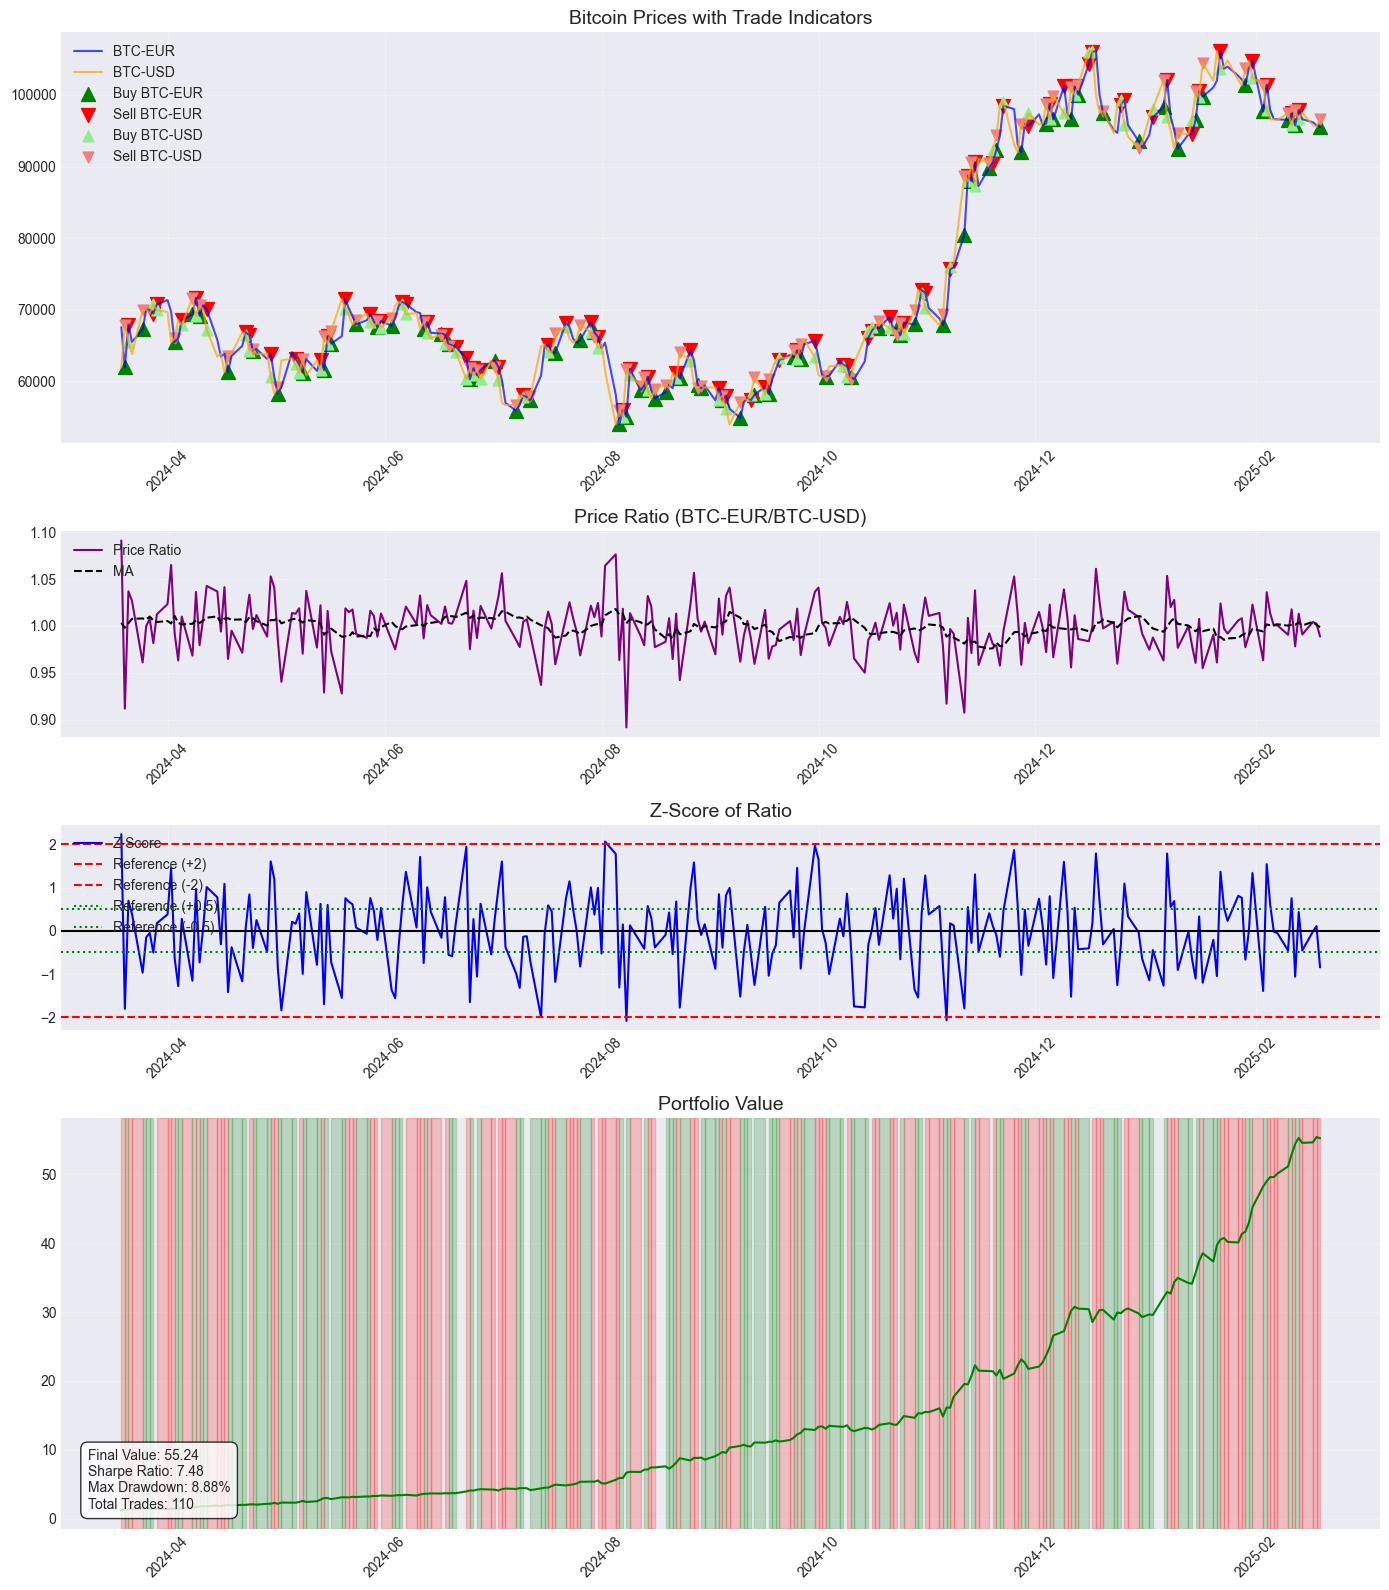


===== PERFORMANCE METRICS =====
Final Portfolio Value: 55.2373
Total Return: 5423.73%
Annualized Return: 42337.27%
Sharpe Ratio: 7.48
Max Drawdown: 8.88%
Total Trades: 28
Win Rate: 62.24%

===== STRATEGY ANALYSIS =====
Total days in the market: 211 out of 241
Percentage of time in the market: 87.6%

Entry Z-scores:
  Mean: 0.87
  Median: 0.84
  Min: 0.02
  Max: 2.08

Exit Z-scores:
  Mean: 0.38
  Median: 0.37
  Min: 0.09
  Max: 0.97


C:\Users\Justin Li\AppData\Local\Temp\ipykernel_5380\3724021934.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['position'] = positions
C:\Users\Justin Li\AppData\Local\Temp\ipykernel_5380\3724021934.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['portfolio_value'] = portfolio_values[1:]
C:\Users\Justin Li\AppData\Local\Temp\ipykernel_5380\3724021934.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [7]:
model = train_rl_agent()
test_env, actions, portfolio_values = test_rl_agent(model)
trades = analyze_strategy(test_env, actions, portfolio_values)